In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
import datetime
from string import ascii_lowercase as alc

import scipy.stats as stats
from sklearn.model_selection import train_test_split

from pyEDM import *

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [287]:
time_slice = slice('1963-10-01','2019-09-01')
pub_dir = '/Users/hkim139/Documents/research/03.manuscripts/2024/swe_causal_manuscript/figs_erl/'

In [3]:
# ENSO nino34
# This just reads the data from an url
# Sea Surface Temperature (SST) data from http://www.cpc.ncep.noaa.gov/data/indices/
url = 'http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True)

# Parse the time and convert to xarray
time = pd.to_datetime(df.YR.astype(str) + '-' + df.MON.astype(str))
nino34 = xr.DataArray(df.ANOM, dims='time', coords={'time':time})
# Apply a 3-month smoothing window
nino34 = nino34.rolling(time=5, min_periods=3, center=True).mean()
# Select the ERA5 period
nino34 = nino34.sel(time=time_slice)

# # find periods of El Ninos and La Ninas
# ElNinos = nino34.where(nino34 >= 0.5, drop=True)
# LaNinas = nino34.where(nino34 <= -0.5, drop=True)

In [4]:
pdo = xr.open_dataset('./data/PDO/pdo.timeseries.ersstv5.nc')
# new_slice = slice('1945-10-01','2019-09-01')
pdo = pdo.sel(time=time_slice)
# pdo_season = pdo.resample(time='QS-DEC').mean(dim='time')

In [5]:
sst_anoms = xr.open_dataset('./data/SST_anoms.nc')
swe_anoms = xr.open_dataset('./data/SWE_anoms.nc')

swe_by_eco_files = glob.glob('./data/snow_by_eco/*.nc')

In [6]:
for i in range(15):
    print(i, swe_by_eco_files[i])

0 ./data/snow_by_eco/snow_Klamath_Mountains.nc
1 ./data/snow_by_eco/snow_Middle_Rockies.nc
2 ./data/snow_by_eco/snow_Central_Basin_and_Range.nc
3 ./data/snow_by_eco/snow_Blue_Mountains.nc
4 ./data/snow_by_eco/snow_Canadian_Rockies.nc
5 ./data/snow_by_eco/snow_Eastern_Cascades_Slopes_and_Foothills.nc
6 ./data/snow_by_eco/snow_Wasatch_and_Uinta_Mountains.nc
7 ./data/snow_by_eco/snow_Sierra_Nevada.nc
8 ./data/snow_by_eco/snow_North_Cascades.nc
9 ./data/snow_by_eco/snow_Northern_Basin_and_Range.nc
10 ./data/snow_by_eco/snow_Columbia_Mountains_Northern_Rockies.nc
11 ./data/snow_by_eco/snow_Arizona_New_Mexico_Mountains.nc
12 ./data/snow_by_eco/snow_Southern_Rockies.nc
13 ./data/snow_by_eco/snow_Idaho_Batholith.nc
14 ./data/snow_by_eco/snow_Cascades.nc


In [7]:
goa_sst = sst_anoms.sel(lat=slice(50,40), lon=slice(220,230))
sst = goa_sst.mean(dim=['lat','lon'])

In [8]:
def CCMsetup(i, col):
    swe_anoms_by_eco = xr.open_dataset(swe_by_eco_files[i])
    swe_anoms_ts = swe_anoms_by_eco.mean(dim='sites').dropna(dim='time')
    
    # generate predicted SWE from SST
    swe = swe_anoms_ts.to_dataframe()
    #sst = goa_sst.mean(dim=['lat','lon']).to_dataframe()
    col = col.to_dataframe()
    #swe_by_eco_files[i]

    df = swe.join(col)
    df = df.dropna()
    df = df.reset_index()
    # df = df.drop(['lat', 'lon'], axis=1)
    
    df['time'] = df['time'].map(lambda x: x.isoformat())
    return(df)

In [77]:
df = CCMsetup(-1, nino34)

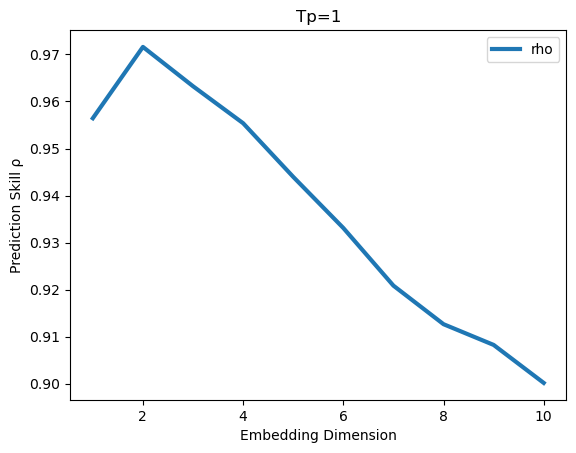

2


In [78]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [11]:
maxN = L - (E+1)
df = df[['time', 'ANOM','swe_level2']]

# look at orange line!
ccm_Ca_enso_lag1 = CCM(dataFrame=df,
                    E = int(E),
                    seed=30,
                    tau=-1,
                    columns='swe_level2',
                    target='ANOM',
                    libSizes=[15,maxN-1,8],
                    sample=100,returnObject=True)
                    # showPlot=True, returnObject=True)

In [12]:
ccm_Ca_enso_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [79]:
ccm_Ca_enso_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # showPlot=True, returnObject=True)

In [14]:
df = CCMsetup(-1, pdo)

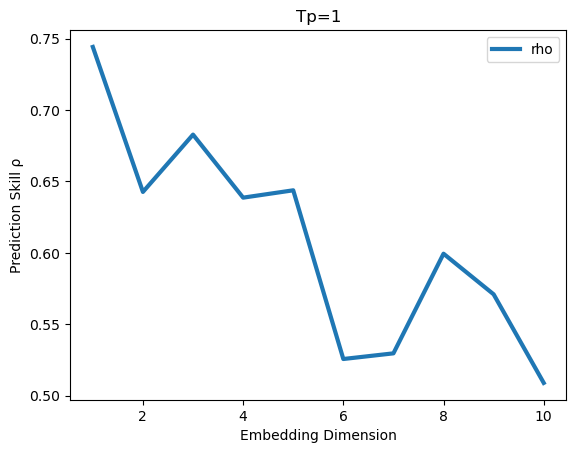

1


In [15]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [16]:
maxN = L - (E+1)

df = df[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_Ca_pdo_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [17]:
ccm_Ca_pdo_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [18]:
ccm_Ca_pdo_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [19]:
df = CCMsetup(-1, sst)

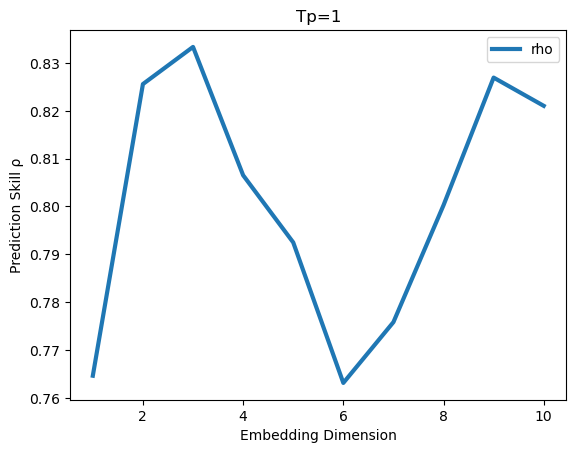

3


In [20]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [21]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_Ca_sst_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # showPlot=True, returnObject=True)

In [22]:
ccm_Ca_sst_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [23]:
ccm_Ca_sst_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [24]:
# fig = plt.figure(figsize=(15,5))
# gs = fig.add_gridspec(1,3)

# ax3 = fig.add_subplot(gs[2])
# ax1 = fig.add_subplot(gs[0], sharey=ax3)
# ax2 = fig.add_subplot(gs[1], sharey=ax3)

# ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='sst:swe_level2')
# ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='ANOM:swe_level2')
# ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='pdo:swe_level2')

# # ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# # ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# # ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')


# ccm_sst_lag3.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
# ccm_enso_lag3.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
# ccm_pdo_lag3.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')


# ccm_sst_lag6.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
# ccm_enso_lag6.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
# ccm_pdo_lag6.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')

# ax1.set_xlabel('Library Size')
# ax2.set_xlabel('Library Size')
# ax3.set_xlabel('Library Size')

# ax1.set_ylabel('CCM Skill')

# ax1.set_title('{}) Lag {}'.format('a', 1), loc='left')
# ax2.set_title('{}) Lag {}'.format('b', 3), loc='left')
# ax3.set_title('{}) Lag {}'.format('c', 6), loc='left')
# plt.tight_layout()

In [25]:
# fig = plt.figure(figsize=(15,5))
# gs = fig.add_gridspec(1,3)

# ax3 = fig.add_subplot(gs[2])
# ax1 = fig.add_subplot(gs[0], sharey=ax3)
# ax2 = fig.add_subplot(gs[1], sharey=ax3)

# ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst')
# ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM')
# ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo')

# # ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# # ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# # ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')


# # ccm_sst_lag3.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag3.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag3.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')
# ccm_sst_lag3.plot(ax=ax2, x='LibSize', y='swe_level2:sst')
# ccm_enso_lag3.plot(ax=ax2, x='LibSize', y='swe_level2:ANOM')
# ccm_pdo_lag3.plot(ax=ax2, x='LibSize', y='swe_level2:pdo')

# # ccm_sst_lag6.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag6.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag6.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')

# ccm_sst_lag6.plot(ax=ax3, x='LibSize', y='swe_level2:sst')
# ccm_enso_lag6.plot(ax=ax3, x='LibSize', y='swe_level2:ANOM')
# ccm_pdo_lag6.plot(ax=ax3, x='LibSize', y='swe_level2:pdo')

# ax1.set_xlabel('Library Size')
# ax2.set_xlabel('Library Size')
# ax3.set_xlabel('Library Size')

# ax1.set_ylabel('CCM Skill')

# ax1.set_title('{}) Lag {}'.format('a', 1), loc='left')
# ax2.set_title('{}) Lag {}'.format('b', 3), loc='left')
# ax3.set_title('{}) Lag {}'.format('c', 6), loc='left')
# plt.tight_layout()

---
---

In [26]:
df_enso = CCMsetup(8, nino34)
df_pdo = CCMsetup(8, pdo)
df_sst = CCMsetup(8, sst)

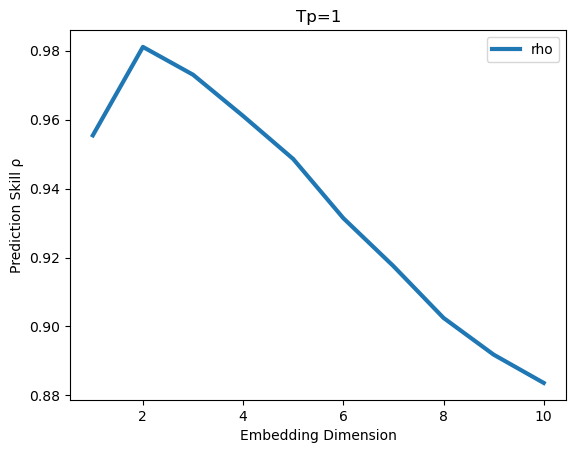

2


In [27]:
L = len(df_enso)
d = EmbedDimension(
    dataFrame=df_enso,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [28]:
maxN = L - (E+1)

df_enso = df_enso[['time', 'ANOM', 'swe_level2']]

# look at orange line!
ccm_NC_enso_lag1 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # showPlot=True, returnObject=True)

In [29]:
ccm_NC_enso_lag3 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [30]:
ccm_NC_enso_lag6 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # showPlot=True, returnObject=True)

---

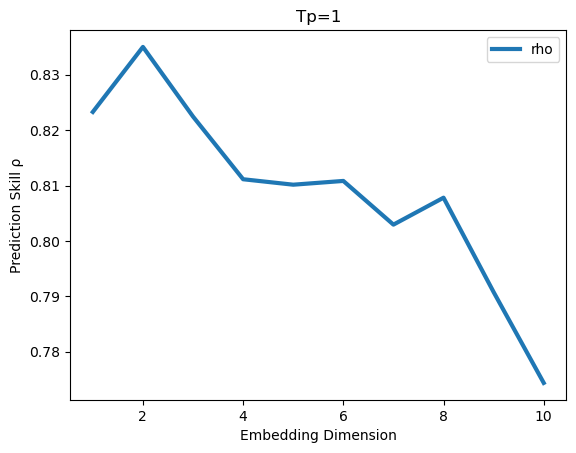

2


In [31]:
L = len(df_pdo)
d = EmbedDimension(
    dataFrame=df_pdo,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [32]:
maxN = L - (E+1)

df_pdo = df_pdo[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_NC_pdo_lag1 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [33]:
ccm_NC_pdo_lag3 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [34]:
ccm_NC_pdo_lag6 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

---

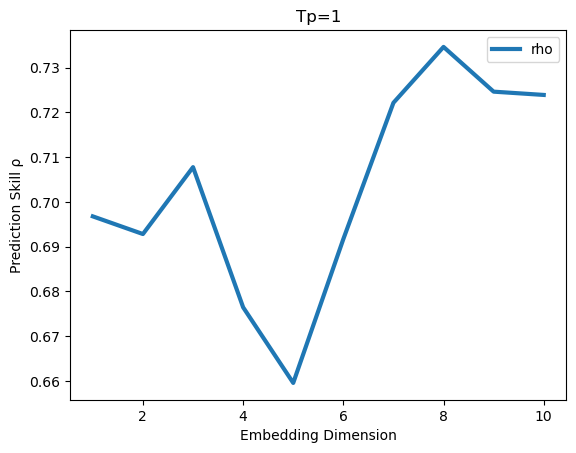

8


In [35]:
L = len(df_sst)
d = EmbedDimension(
    dataFrame=df_sst,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [36]:
maxN = L - (E+1)

df_sst = df_sst[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_NC_sst_lag1 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [37]:
# look at orange line!
ccm_NC_sst_lag3 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [38]:
# look at orange line!
ccm_NC_sst_lag6 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [39]:
# fig = plt.figure(figsize=(15,5))
# gs = fig.add_gridspec(1,3)

# ax3 = fig.add_subplot(gs[2])
# ax1 = fig.add_subplot(gs[0], sharey=ax3)
# ax2 = fig.add_subplot(gs[1], sharey=ax3)

# # ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='pdo:swe_level2')

# # # ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# # # ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# # # ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')


# # ccm_sst_lag3.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag3.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag3.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')


# # ccm_sst_lag6.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag6.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag6.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')

# ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst')
# ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM')
# ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo')

# # ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# # ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# # ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')


# # ccm_sst_lag3.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag3.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag3.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')
# ccm_sst_lag3.plot(ax=ax2, x='LibSize', y='swe_level2:sst')
# ccm_enso_lag3.plot(ax=ax2, x='LibSize', y='swe_level2:ANOM')
# ccm_pdo_lag3.plot(ax=ax2, x='LibSize', y='swe_level2:pdo')

# # ccm_sst_lag6.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag6.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag6.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')

# ccm_sst_lag6.plot(ax=ax3, x='LibSize', y='swe_level2:sst')
# ccm_enso_lag6.plot(ax=ax3, x='LibSize', y='swe_level2:ANOM')
# ccm_pdo_lag6.plot(ax=ax3, x='LibSize', y='swe_level2:pdo')

# ax1.set_xlabel('Library Size')
# ax2.set_xlabel('Library Size')
# ax3.set_xlabel('Library Size')

# ax1.set_ylabel('CCM Skill')

# ax1.set_title('{}) Lag {}'.format('a', 1), loc='left')
# ax2.set_title('{}) Lag {}'.format('b', 3), loc='left')
# ax3.set_title('{}) Lag {}'.format('c', 6), loc='left')
# plt.tight_layout()

---
---

In [40]:
df_enso = CCMsetup(10, nino34)
df_pdo = CCMsetup(10, pdo)
df_sst = CCMsetup(10, sst)

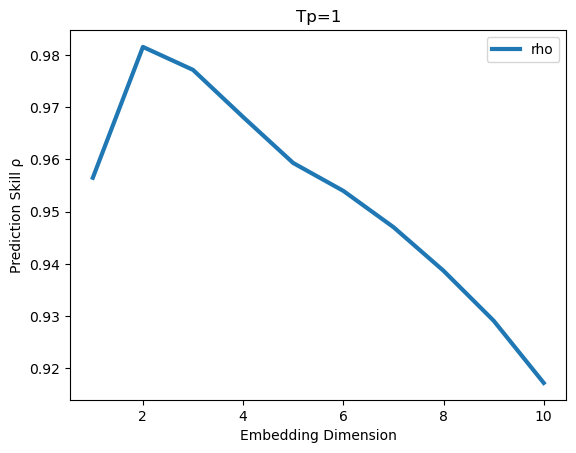

2


In [41]:
L = len(df_enso)
d = EmbedDimension(
    dataFrame=df_enso,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [42]:
maxN = L - (E+1)

df_enso = df_enso[['time', 'ANOM', 'swe_level2']]

# look at orange line!
ccm_CM_enso_lag1 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # showPlot=True, returnObject=True)

In [43]:
ccm_CM_enso_lag3 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [44]:
ccm_CM_enso_lag6 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # showPlot=True, returnObject=True)

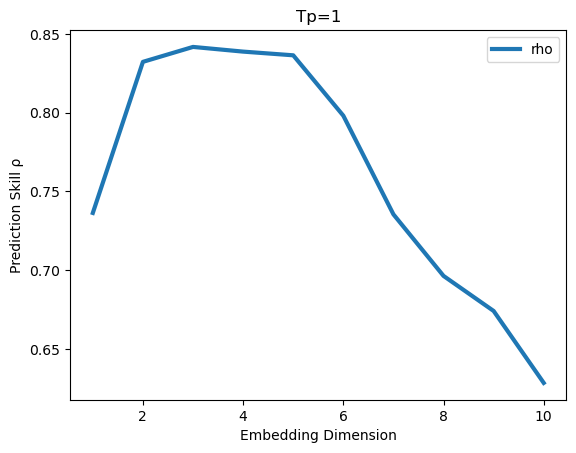

3


In [45]:
L = len(df_pdo)
d = EmbedDimension(
    dataFrame=df_pdo,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [46]:
maxN = L - (E+1)

df_pdo = df_pdo[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_CM_pdo_lag1 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [47]:
ccm_CM_pdo_lag3 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [48]:
ccm_CM_pdo_lag6 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

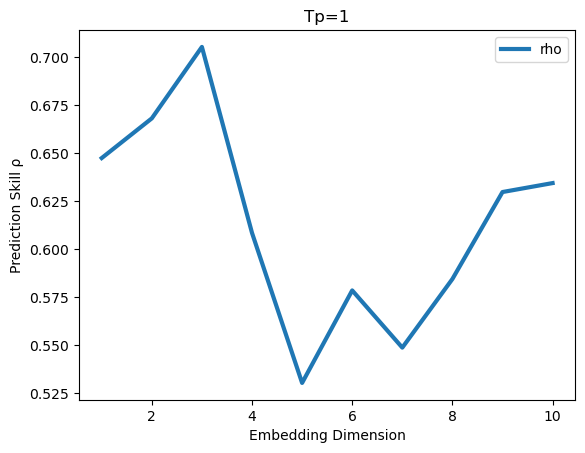

3


In [49]:
L = len(df_sst)
d = EmbedDimension(
    dataFrame=df_sst,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [50]:
maxN = L - (E+1)

df_sst = df_sst[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_CM_sst_lag1 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [51]:
# look at orange line!
ccm_CM_sst_lag3 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [52]:
# look at orange line!
ccm_CM_sst_lag6 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [53]:
# fig = plt.figure(figsize=(15,5))
# gs = fig.add_gridspec(1,3)

# ax3 = fig.add_subplot(gs[2])
# ax1 = fig.add_subplot(gs[0], sharey=ax3)
# ax2 = fig.add_subplot(gs[1], sharey=ax3)

# # ccm_sst_lag1.libMeans.plot(ax=ax1, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag1.libMeans.plot(ax=ax1, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag1.libMeans.plot(ax=ax1, x='LibSize', y='pdo:swe_level2')

# # # ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# # # ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# # # ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')

# # ccm_sst_lag3.libMeans.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag3.libMeans.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag3.libMeans.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')


# # ccm_sst_lag6.libMeans.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag6.libMeans.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag6.libMeans.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')

# ccm_sst_lag1.libMeans.plot(ax=ax1, x='LibSize', y='swe_level2:sst')
# ccm_enso_lag1.libMeans.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM')
# ccm_pdo_lag1.libMeans.plot(ax=ax1, x='LibSize', y='swe_level2:pdo')

# # ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# # ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# # ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')


# # ccm_sst_lag3.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag3.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag3.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')
# ccm_sst_lag3.libMeans.plot(ax=ax2, x='LibSize', y='swe_level2:sst')
# ccm_enso_lag3.libMeans.plot(ax=ax2, x='LibSize', y='swe_level2:ANOM')
# ccm_pdo_lag3.libMeans.plot(ax=ax2, x='LibSize', y='swe_level2:pdo')

# # ccm_sst_lag6.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag6.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag6.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')

# ccm_sst_lag6.libMeans.plot(ax=ax3, x='LibSize', y='swe_level2:sst')
# ccm_enso_lag6.libMeans.plot(ax=ax3, x='LibSize', y='swe_level2:ANOM')
# ccm_pdo_lag6.libMeans.plot(ax=ax3, x='LibSize', y='swe_level2:pdo')

# ax1.set_xlabel('Library Size')
# ax2.set_xlabel('Library Size')
# ax3.set_xlabel('Library Size')

# ax1.set_ylabel('CCM Skill')

# ax1.set_title('{}) Lag {}'.format('a', 1), loc='left')
# ax2.set_title('{}) Lag {}'.format('b', 3), loc='left')
# ax3.set_title('{}) Lag {}'.format('c', 6), loc='left')
# plt.tight_layout()

In [54]:
# fig = plt.figure(figsize=(15,5))
# gs = fig.add_gridspec(1,3)

# ax3 = fig.add_subplot(gs[2])
# ax1 = fig.add_subplot(gs[0], sharey=ax3)
# ax2 = fig.add_subplot(gs[1], sharey=ax3)

# ccm_sst_lag1.libMeans.plot(ax=ax1, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag1.libMeans.plot(ax=ax1, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag1.libMeans.plot(ax=ax1, x='LibSize', y='pdo:swe_level2')

# # # ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# # # ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# # # ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')

# ccm_sst_lag3.libMeans.plot(ax=ax2, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag3.libMeans.plot(ax=ax2, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag3.libMeans.plot(ax=ax2, x='LibSize', y='pdo:swe_level2')


# ccm_sst_lag6.libMeans.plot(ax=ax3, x='LibSize', y='sst:swe_level2')
# # ccm_enso_lag6.libMeans.plot(ax=ax3, x='LibSize', y='ANOM:swe_level2')
# # ccm_pdo_lag6.libMeans.plot(ax=ax3, x='LibSize', y='pdo:swe_level2')


# # ccm_sst_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:sst', ls='--')
# # ccm_enso_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', ls='--')
# # ccm_pdo_lag1.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', ls='--')





# ax1.set_xlabel('Library Size')
# ax2.set_xlabel('Library Size')
# ax3.set_xlabel('Library Size')

# ax1.set_ylabel('CCM Skill')

# ax1.set_title('{}) Lag {}'.format('a', 1), loc='left')
# ax2.set_title('{}) Lag {}'.format('b', 3), loc='left')
# ax3.set_title('{}) Lag {}'.format('c', 6), loc='left')
# plt.tight_layout()

In [55]:
df_enso = CCMsetup(5, nino34)
df_pdo = CCMsetup(5, pdo)
df_sst = CCMsetup(5, sst)

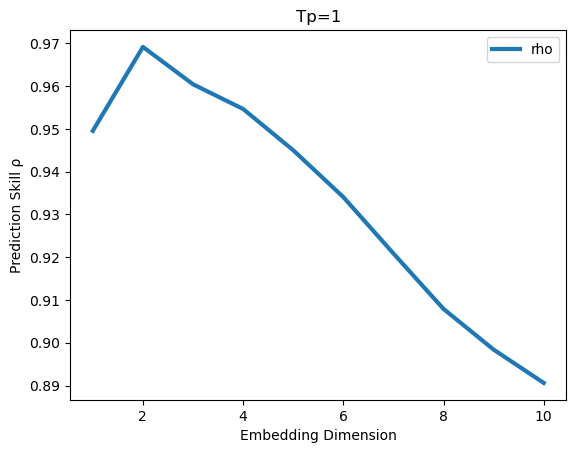

2


In [56]:
L = len(df_enso)
d = EmbedDimension(
    dataFrame=df_enso,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [57]:
maxN = L - (E+1)

df_enso = df_enso[['time', 'ANOM', 'swe_level2']]

# look at orange line!
ccm_EC_enso_lag1 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # showPlot=True, returnObject=True)

In [58]:
ccm_EC_enso_lag3 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [59]:
ccm_EC_enso_lag6 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

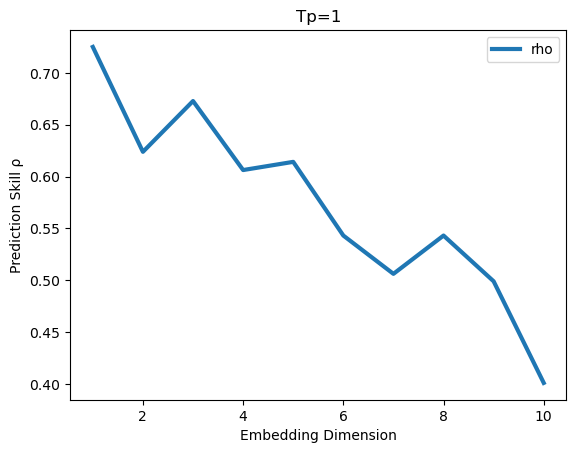

1


In [60]:
L = len(df_pdo)
d = EmbedDimension(
    dataFrame=df_pdo,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [61]:
maxN = L - (E+1)

df_pdo = df_pdo[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_EC_pdo_lag1 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [62]:
# look at orange line!
ccm_EC_pdo_lag3 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [63]:
# look at orange line!
ccm_EC_pdo_lag6 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

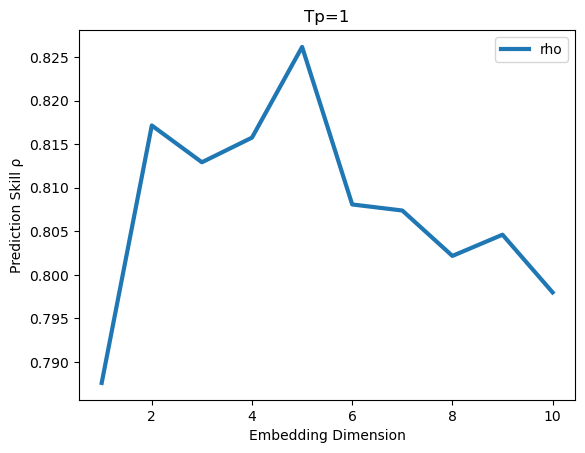

5


In [64]:
L = len(df_sst)
d = EmbedDimension(
    dataFrame=df_sst,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

In [65]:
maxN = L - (E+1)

df_sst = df_sst[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_EC_sst_lag1 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [66]:
ccm_EC_sst_lag3 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [67]:
ccm_EC_sst_lag6 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # showPlot=True, returnObject=True)

In [122]:
import cartopy
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [219]:
# coast_ecos = ['Cascades',
#               'North Cascades',
#               'Eastern Cascades Slopes and Foothills',
#               'Columbia Mountains/Northern Rockies']

coast_ecos = ['North Cascades',
              'Cascades',
              'Eastern Cascades Slopes and Foothills',
              'Columbia Mountains/Northern Rockies']

In [214]:
# read in NA ECO_LEVEL 3 raster files
gdf = gpd.read_file('../data/NA_CEC_Eco_Level3/')

wus_eco = gdf[gdf['NA_L3NAME'].isin(coast_ecos)]

# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
wus_eco = wus_eco.to_crs(crs_proj4)

In [196]:
pub_folder = '/Users/hkim139/Documents/research/03.manuscripts/2024/swe_causal_manuscript/figs_erl/'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


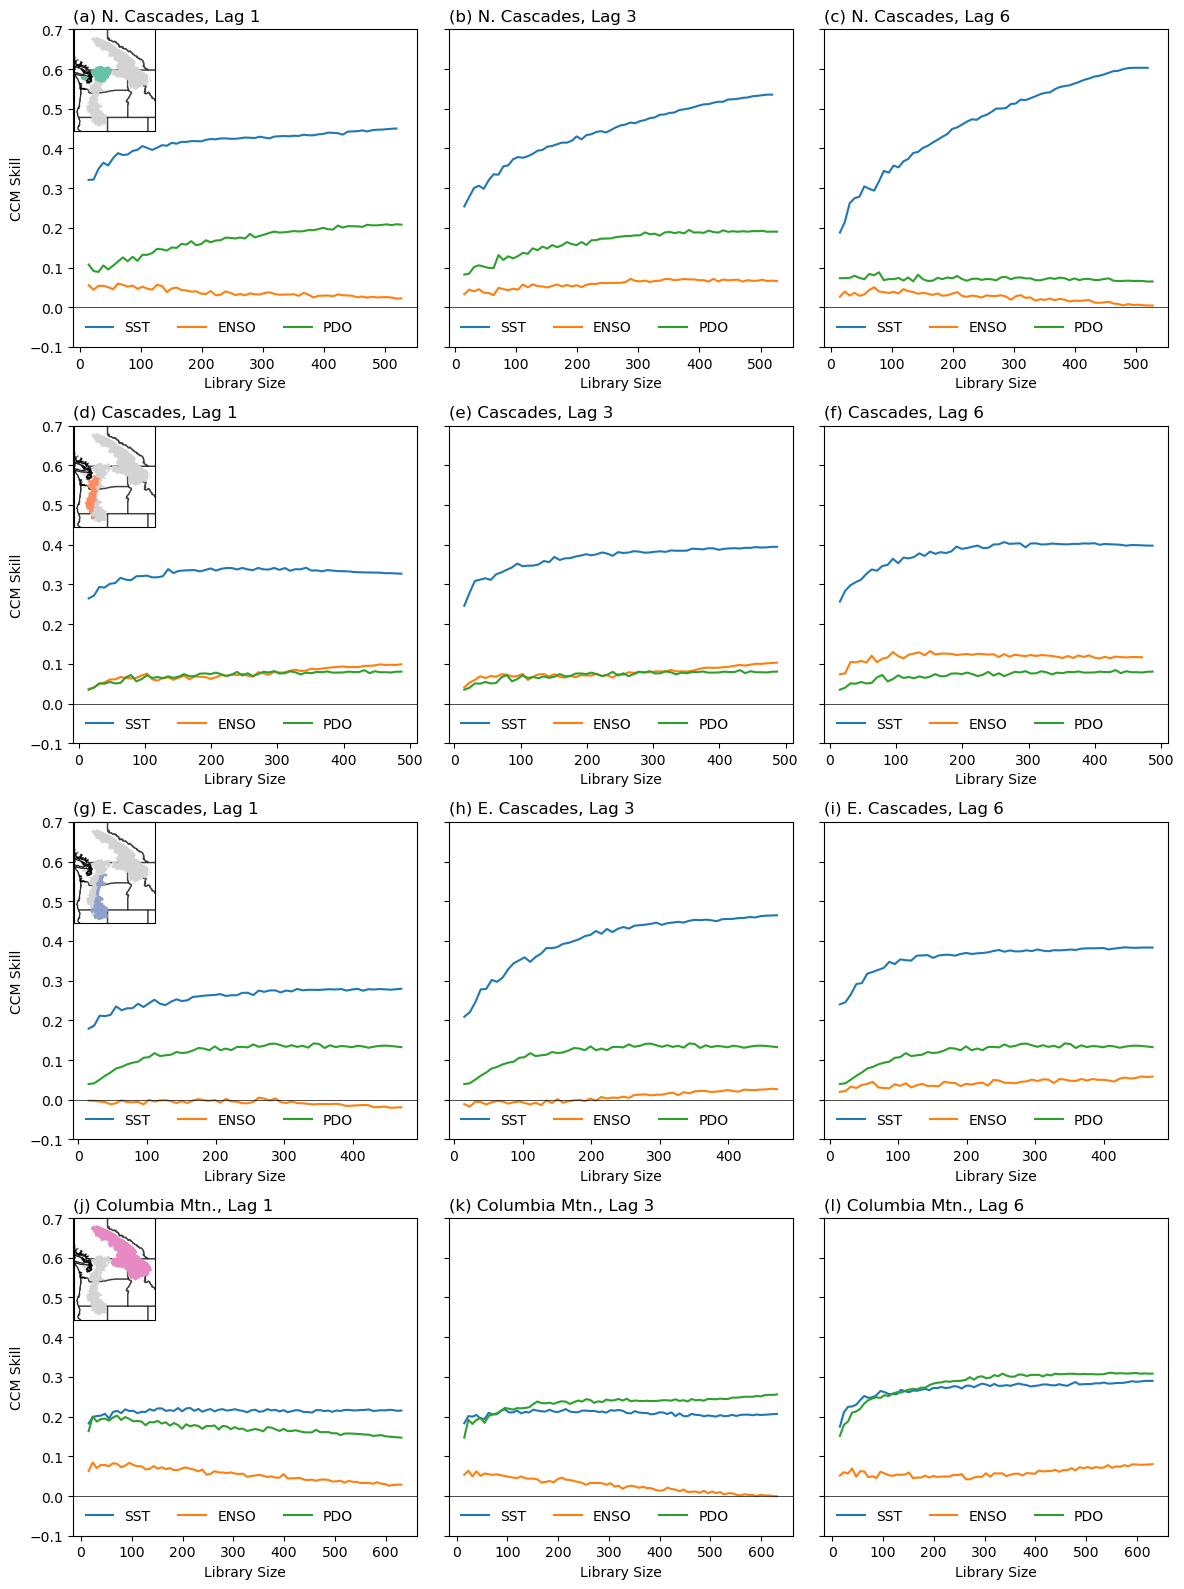

In [342]:
fig = plt.figure(figsize=(12,16))
gs = fig.add_gridspec(4,3)

ax3 = fig.add_subplot(gs[0,2])
ax1 = fig.add_subplot(gs[0,0], sharey=ax3)
ax2 = fig.add_subplot(gs[0,1], sharey=ax3)

ax4 = fig.add_subplot(gs[1,0], sharey=ax3)
ax5 = fig.add_subplot(gs[1,1], sharey=ax3)
ax6 = fig.add_subplot(gs[1,2], sharey=ax3)

ax7 = fig.add_subplot(gs[2,0], sharey=ax3)
ax8 = fig.add_subplot(gs[2,1], sharey=ax3)
ax9 = fig.add_subplot(gs[2,2], sharey=ax3)

ax10 = fig.add_subplot(gs[3,0], sharey=ax3)
ax11 = fig.add_subplot(gs[3,1], sharey=ax3)
ax12 = fig.add_subplot(gs[3,2], sharey=ax3)


ccm_NC_sst_lag1.libMeans.plot(ax=ax1, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_NC_enso_lag1.libMeans.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_NC_pdo_lag1.libMeans.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_NC_sst_lag3.libMeans.plot(ax=ax2, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_NC_enso_lag3.libMeans.plot(ax=ax2, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_NC_pdo_lag3.libMeans.plot(ax=ax2, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_NC_sst_lag6.libMeans.plot(ax=ax3, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_NC_enso_lag6.libMeans.plot(ax=ax3, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_NC_pdo_lag6.libMeans.plot(ax=ax3, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_Ca_sst_lag1.libMeans.plot(ax=ax4, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_Ca_enso_lag1.libMeans.plot(ax=ax4, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_Ca_pdo_lag1.libMeans.plot(ax=ax4, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_Ca_sst_lag3.libMeans.plot(ax=ax5, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_Ca_enso_lag3.libMeans.plot(ax=ax5, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_Ca_pdo_lag3.libMeans.plot(ax=ax5, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_Ca_sst_lag6.libMeans.plot(ax=ax6, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_Ca_enso_lag6.libMeans.plot(ax=ax6, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_Ca_pdo_lag6.libMeans.plot(ax=ax6, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_EC_sst_lag1.libMeans.plot(ax=ax7, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_EC_enso_lag1.libMeans.plot(ax=ax7, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_EC_pdo_lag1.libMeans.plot(ax=ax7, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_EC_sst_lag3.libMeans.plot(ax=ax8, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_EC_enso_lag3.libMeans.plot(ax=ax8, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_EC_pdo_lag3.libMeans.plot(ax=ax8, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_EC_sst_lag6.libMeans.plot(ax=ax9, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_EC_enso_lag6.libMeans.plot(ax=ax9, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_EC_pdo_lag6.libMeans.plot(ax=ax9, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_CM_sst_lag1.libMeans.plot(ax=ax10, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_CM_enso_lag1.libMeans.plot(ax=ax10, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_CM_pdo_lag1.libMeans.plot(ax=ax10, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_CM_sst_lag3.libMeans.plot(ax=ax11, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_CM_enso_lag3.libMeans.plot(ax=ax11, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_CM_pdo_lag3.libMeans.plot(ax=ax11, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_CM_sst_lag6.libMeans.plot(ax=ax12, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_CM_enso_lag6.libMeans.plot(ax=ax12, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_CM_pdo_lag6.libMeans.plot(ax=ax12, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ax1.set_xlabel('Library Size')
ax2.set_xlabel('Library Size')
ax3.set_xlabel('Library Size')
ax4.set_xlabel('Library Size')
ax5.set_xlabel('Library Size')
ax6.set_xlabel('Library Size')
ax7.set_xlabel('Library Size')
ax8.set_xlabel('Library Size')
ax9.set_xlabel('Library Size')
ax10.set_xlabel('Library Size')
ax11.set_xlabel('Library Size')
ax12.set_xlabel('Library Size')

ax1.set_ylabel('CCM Skill')
ax4.set_ylabel('CCM Skill')
ax7.set_ylabel('CCM Skill')
ax10.set_ylabel('CCM Skill')

ax1.set_title('({}) {}, Lag {}'.format('a', 'N. Cascades', 1), loc='left')
ax2.set_title('({}) {}, Lag {}'.format('b', 'N. Cascades', 3), loc='left')
ax3.set_title('({}) {}, Lag {}'.format('c', 'N. Cascades', 6), loc='left')

ax4.set_title('({}) {}, Lag {}'.format('d', 'Cascades', 1), loc='left')
ax5.set_title('({}) {}, Lag {}'.format('e', 'Cascades', 3), loc='left')
ax6.set_title('({}) {}, Lag {}'.format('f', 'Cascades', 6), loc='left')

ax7.set_title('({}) {}, Lag {}'.format('g', 'E. Cascades', 1), loc='left')
ax8.set_title('({}) {}, Lag {}'.format('h', 'E. Cascades', 3), loc='left')
ax9.set_title('({}) {}, Lag {}'.format('i', 'E. Cascades', 6), loc='left')

ax10.set_title('({}) {}, Lag {}'.format('j', 'Columbia Mtn.', 1), loc='left')
ax11.set_title('({}) {}, Lag {}'.format('k', 'Columbia Mtn.', 3), loc='left')
ax12.set_title('({}) {}, Lag {}'.format('l', 'Columbia Mtn.', 6), loc='left')

ax1.set_ylim([-0.1,0.7])
ax1.legend(ncols=3, loc='lower left', frameon=False)
ax2.legend(ncols=3, loc='lower left', frameon=False)
ax3.legend(ncols=3, loc='lower left', frameon=False)
ax4.legend(ncols=3, loc='lower left', frameon=False)
ax5.legend(ncols=3, loc='lower left', frameon=False)
ax6.legend(ncols=3, loc='lower left', frameon=False)
ax7.legend(ncols=3, loc='lower left', frameon=False)
ax8.legend(ncols=3, loc='lower left', frameon=False)
ax9.legend(ncols=3, loc='lower left', frameon=False)
ax10.legend(ncols=3, loc='lower left', frameon=False)
ax11.legend(ncols=3, loc='lower left', frameon=False)
ax12.legend(ncols=3, loc='lower left', frameon=False)

ax1.axhline(0, color='k', lw=0.5)
ax2.axhline(0, color='k', lw=0.5)
ax3.axhline(0, color='k', lw=0.5)
ax4.axhline(0, color='k', lw=0.5)
ax5.axhline(0, color='k', lw=0.5)
ax6.axhline(0, color='k', lw=0.5)
ax7.axhline(0, color='k', lw=0.5)
ax8.axhline(0, color='k', lw=0.5)
ax9.axhline(0, color='k', lw=0.5)
ax10.axhline(0, color='k', lw=0.5)
ax11.axhline(0, color='k', lw=0.5)
ax12.axhline(0, color='k', lw=0.5)

c_Set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

for i, a in enumerate([ax1, ax4, ax7, ax10]):
    coast_ecos = ['North Cascades', 'Cascades', 'Eastern Cascades Slopes and Foothills','Columbia Mountains/Northern Rockies']
    inset_ax = inset_axes(a, width="24%", height="32%", loc='upper left',
                              axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                              axes_kwargs=dict(
                                  map_projection=ccrs.PlateCarree()), borderpad=0)
    plotting = coast_ecos.pop(i)
    # [-130, -113, 40, 55], crs=ccrs.PlateCarree()
    inset_ax.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
    inset_ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    inset_ax.add_feature(cfeature.STATES, alpha=0.5)
    # wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].boundary.plot(ax=inset_ax, color='black', alpha=0.5)
    wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].plot(ax=inset_ax, transform=crs, color='lightgrey', zorder=2)
    inset_ax.add_geometries(wus_eco[wus_eco['NA_L3NAME']==plotting]['geometry'],
                            crs=ccrs.PlateCarree(), color=c_Set2[i])

plt.tight_layout()
plt.savefig(pub_folder+'fig5a_5l.eps', bbox_inches='tight', facecolor='w')

In [552]:
from sklearn.metrics import r2_score

def ccm_projections(ccm_obj):
    ccm_obj.RevMap.FindNeighbors()
    ccm_obj.RevMap.Project()
    ccm_obj.RevMap.FormatProjection()

    ccm_re = ccm_obj.RevMap.Projection
    ccm_re['dtime'] = ccm_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
    return(ccm_re)


def lagged_regression(df, lag):
    X = df['sst'][0:-lag].to_numpy()
    y = df['swe_level2'][lag:].to_numpy()

    x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=42)
    m, b, rho, p, std_err = stats.linregress(x_train, y_train)
    y_pred = m*X - b
    r2x = r2_score(y, y_pred)
    print(r2x)
    return(y_pred)

In [589]:
swe_re_ccm_l1_Ca = ccm_projections(ccm_Ca_sst_lag1)
swe_re_ccm_l3_Ca = ccm_projections(ccm_Ca_sst_lag3)
swe_re_ccm_l6_Ca = ccm_projections(ccm_Ca_sst_lag6)

In [590]:
df_swe_Ca = CCMsetup(-1, sst)

In [591]:
swe_re_lm_l1_Ca = lagged_regression(df_swe_Ca, 1)
swe_re_lm_l3_Ca = lagged_regression(df_swe_Ca, 3)
swe_re_lm_l6_Ca = lagged_regression(df_swe_Ca, 6)

0.15207987232525533
0.09753185032584932
0.06305721393971475


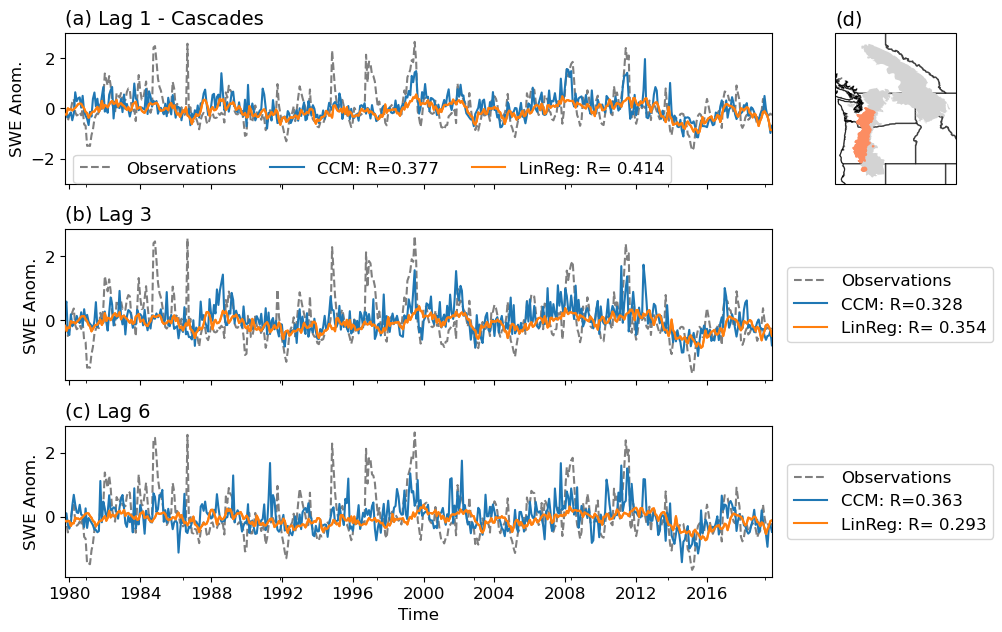

In [592]:
coast_ecos = ['North Cascades', 'Cascades',
              'Eastern Cascades Slopes and Foothills',
              'Columbia Mountains/Northern Rockies']
df_swe_Ca['dtime'] = df_swe_Ca['time'].map(lambda x: datetime.datetime.fromisoformat(x))

# fig, ax = plt.subplots(figsize=(15,5))
fig = plt.figure(layout='tight', figsize=(13,8))
gs = fig.add_gridspec(3,2, width_ratios=[2,1], wspace=-0.1, hspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[2,0], sharex=ax1)

ax_map = fig.add_subplot(gs[0,1],
                         projection=ccrs.PlateCarree(central_longitude=180))
# - Lag 1 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l1_Ca, df_swe_Ca['swe_level2'][1:])
r2, p2 = stats.pearsonr(swe_re_ccm_l1_Ca['Observations'], swe_re_ccm_l1_Ca['Predictions'])

ax1.plot(df_swe_Ca['dtime'][1:], swe_re_lm_l1_Ca, color='tab:orange', zorder=5)
swe_re_ccm_l1_Ca.plot(ax=ax1, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l1_Ca.plot(ax=ax1, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax1.plot(df_swe_Ca['dtime'][1:], swe_re_lm_l1_Ca, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax1.set_title('(a) Lag 1 - Cascades', loc='left', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SWE Anom.', fontsize=12)
ax1.legend(ncols=3, bbox_to_anchor=(0, 0.1), loc='center left', fontsize=12)
ax1.set_xlim([swe_re_ccm_l1_Ca.dtime[0], swe_re_ccm_l1_Ca.dtime.iloc[-1]])

# - Lag 3 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l3_Ca, df_swe_Ca['swe_level2'][3:])
r2, p2 = stats.pearsonr(swe_re_ccm_l3_Ca['Observations'], swe_re_ccm_l3_Ca['Predictions'])

ax2.plot(df_swe_Ca['dtime'][3:], swe_re_lm_l3_Ca, color='tab:orange', zorder=5)
swe_re_ccm_l3_Ca.plot(ax=ax2, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l3_Ca.plot(ax=ax2, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax2.plot(df_swe_Ca['dtime'][3:], swe_re_lm_l3_Ca, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax2.set_title('(b) Lag 3', loc='left', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('SWE Anom.', fontsize=12)
ax2.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax2.set_xlim([swe_re_ccm_l6_Ca.dtime[0], swe_re_ccm_l6_Ca.dtime.iloc[-1]])

# - Lag 6 ---------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l6_Ca, df_swe_Ca['swe_level2'][6:])
r2, p2 = stats.pearsonr(swe_re_ccm_l6_Ca['Observations'], swe_re_ccm_l6_Ca['Predictions'])

ax3.plot(df_swe_Ca['dtime'][6:], swe_re_lm_l6_Ca, color='tab:orange', zorder=5)
swe_re_ccm_l6_Ca.plot(ax=ax3, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l6_Ca.plot(ax=ax3, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax3.plot(df_swe_Ca['dtime'][6:], swe_re_lm_l6_Ca, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax3.set_title('(c) Lag 6', loc='left', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('SWE Anom.', fontsize=12)
ax3.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax3.set_xlim([swe_re_ccm_l6_Ca.dtime[0], swe_re_ccm_l6_Ca.dtime.iloc[-1]])
plt.setp(ax3.get_xticklabels(), horizontalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

c_Set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].plot(ax=ax_map,
                                                    transform=crs,
                                                    color='lightgrey', zorder=2)
ax_map.add_geometries(wus_eco[wus_eco['NA_L3NAME']=="Cascades"]['geometry'],
                            crs=ccrs.PlateCarree(), color=c_Set2[1], zorder=3)
ax_map.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
ax_map.coastlines(resolution='50m', color='black', linewidth=0.5)
ax_map.add_feature(cfeature.STATES, alpha=0.5)
ax_map.set_title('(d)', loc='left', fontsize=14)

ax1.set_ylim([-3,3])

# plt.savefig(pub_dir+'fig6a_6d.eps',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)

plt.show()

In [593]:
swe_re_ccm_l1_NC = ccm_projections(ccm_NC_sst_lag1)
swe_re_ccm_l3_NC = ccm_projections(ccm_NC_sst_lag3)
swe_re_ccm_l6_NC = ccm_projections(ccm_NC_sst_lag6)

df_swe_NC = CCMsetup(8, sst)

In [594]:
swe_re_lm_l1_NC = lagged_regression(df_swe_NC, 1)
swe_re_lm_l3_NC = lagged_regression(df_swe_NC, 3)
swe_re_lm_l6_NC = lagged_regression(df_swe_NC, 6)

0.11923815406957161
0.07519227529230554
0.0479963444048922


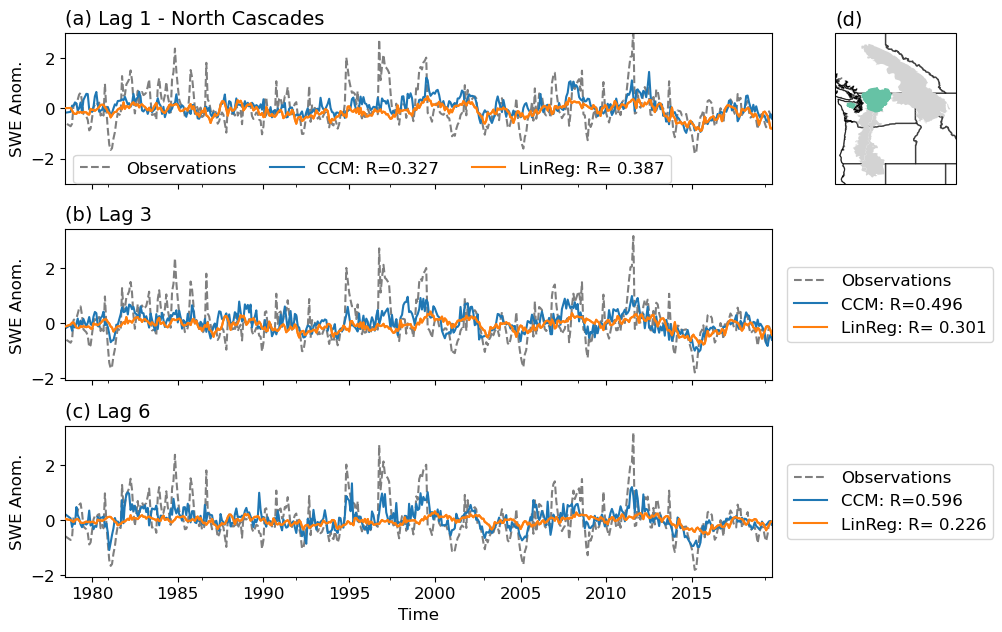

In [595]:
coast_ecos = ['Cascades', 'North Cascades',
              'Eastern Cascades Slopes and Foothills',
              'Columbia Mountains/Northern Rockies']
df_swe_NC['dtime'] = df_swe_NC['time'].map(lambda x: datetime.datetime.fromisoformat(x))

# fig, ax = plt.subplots(figsize=(15,5))
fig = plt.figure(layout='tight', figsize=(13,8))
gs = fig.add_gridspec(3,2, width_ratios=[2,1], wspace=-0.1, hspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[2,0], sharex=ax1)

ax_map = fig.add_subplot(gs[0,1],
                         projection=ccrs.PlateCarree(central_longitude=180))
# - Lag 1 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l1_NC, df_swe_NC['swe_level2'][1:])
r2, p2 = stats.pearsonr(swe_re_ccm_l1_NC['Observations'], swe_re_ccm_l1_NC['Predictions'])

ax1.plot(df_swe_NC['dtime'][1:], swe_re_lm_l1_NC, color='tab:orange', zorder=5)
swe_re_ccm_l1_NC.plot(ax=ax1, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l1_NC.plot(ax=ax1, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax1.plot(df_swe_NC['dtime'][1:], swe_re_lm_l1_NC, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax1.set_title('(a) Lag 1 - North Cascades', loc='left', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SWE Anom.', fontsize=12)
ax1.legend(ncols=3, bbox_to_anchor=(0, 0.1), loc='center left', fontsize=12)
ax1.set_xlim([swe_re_ccm_l1_NC.dtime[0], swe_re_ccm_l1_NC.dtime.iloc[-1]])

# - Lag 3 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l3_NC, df_swe_NC['swe_level2'][3:])
r2, p2 = stats.pearsonr(swe_re_ccm_l3_NC['Observations'], swe_re_ccm_l3_NC['Predictions'])

ax2.plot(df_swe_NC['dtime'][3:], swe_re_lm_l3_NC, color='tab:orange', zorder=5)
swe_re_ccm_l3_NC.plot(ax=ax2, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l3_NC.plot(ax=ax2, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax2.plot(df_swe_NC['dtime'][3:], swe_re_lm_l3_NC, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax2.set_title('(b) Lag 3', loc='left', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('SWE Anom.', fontsize=12)
ax2.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax2.set_xlim([swe_re_ccm_l6_NC.dtime[0], swe_re_ccm_l6_NC.dtime.iloc[-1]])

# - Lag 6 ---------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l6_NC, df_swe_NC['swe_level2'][6:])
r2, p2 = stats.pearsonr(swe_re_ccm_l6_NC['Observations'], swe_re_ccm_l6_NC['Predictions'])

ax3.plot(df_swe_NC['dtime'][6:], swe_re_lm_l6_NC, color='tab:orange', zorder=5)
swe_re_ccm_l6_NC.plot(ax=ax3, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l6_NC.plot(ax=ax3, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax3.plot(df_swe_NC['dtime'][6:], swe_re_lm_l6_NC, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax3.set_title('(c) Lag 6', loc='left', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('SWE Anom.', fontsize=12)
ax3.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax3.set_xlim([swe_re_ccm_l6_NC.dtime[0], swe_re_ccm_l6_NC.dtime.iloc[-1]])
plt.setp(ax3.get_xticklabels(), horizontalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].plot(ax=ax_map,
                                                    transform=crs,
                                                    color='lightgrey', zorder=2)
ax_map.add_geometries(wus_eco[wus_eco['NA_L3NAME']=="North Cascades"]['geometry'],
                            crs=ccrs.PlateCarree(), color=c_Set2[0], zorder=3)
ax_map.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
ax_map.coastlines(resolution='50m', color='black', linewidth=0.5)
ax_map.add_feature(cfeature.STATES, alpha=0.5)

ax_map.set_title('(d)', loc='left', fontsize=14)
ax1.set_ylim([-3,3])

# plt.savefig(pub_dir+'fig7a_7d.eps',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)

plt.show()

In [596]:
swe_re_ccm_l1_CM = ccm_projections(ccm_CM_sst_lag1)
swe_re_ccm_l3_CM = ccm_projections(ccm_CM_sst_lag3)
swe_re_ccm_l6_CM = ccm_projections(ccm_CM_sst_lag6)

df_swe_CM = CCMsetup(10, sst)

In [597]:
swe_re_lm_l1_CM = lagged_regression(df_swe_CM, 1)
swe_re_lm_l3_CM = lagged_regression(df_swe_CM, 3)
swe_re_lm_l6_CM = lagged_regression(df_swe_CM, 6)

0.07334555846753321
0.03420734872150266
0.020997124797725752


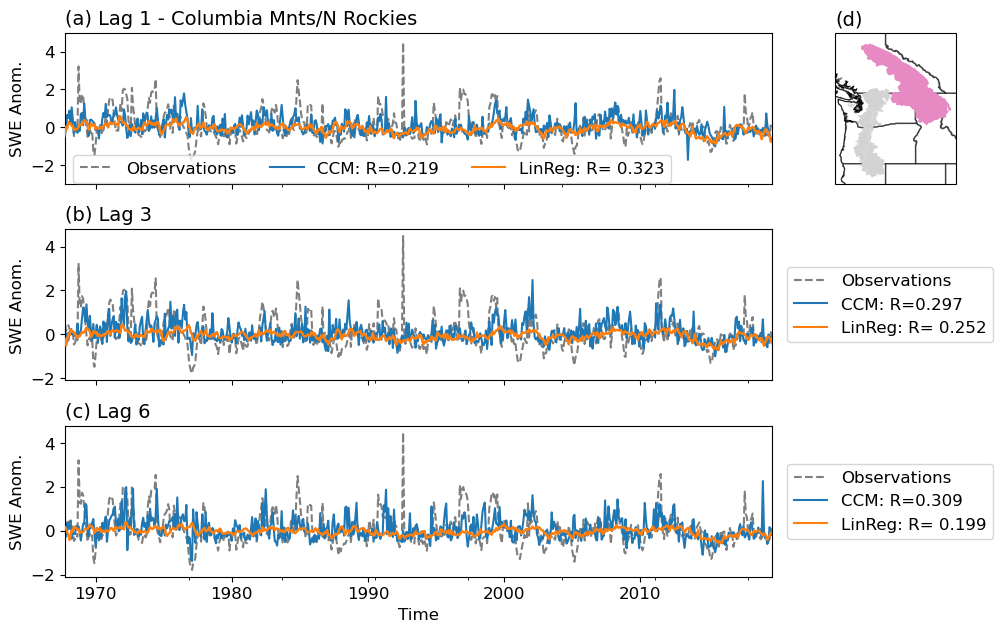

In [598]:
 coast_ecos = ['Cascades', 'North Cascades',
               'Eastern Cascades Slopes and Foothills',
               'Columbia Mountains/Northern Rockies']
df_swe_CM['dtime'] = df_swe_CM['time'].map(lambda x: datetime.datetime.fromisoformat(x))

# fig, ax = plt.subplots(figsize=(15,5))
fig = plt.figure(layout='tight', figsize=(13,8))
gs = fig.add_gridspec(3,2, width_ratios=[2,1], wspace=-0.1, hspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[2,0], sharex=ax1)

ax_map = fig.add_subplot(gs[0,1],
                         projection=ccrs.PlateCarree(central_longitude=180))
# - Lag 1 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l1_CM, df_swe_CM['swe_level2'][1:])
r2, p2 = stats.pearsonr(swe_re_ccm_l1_CM['Observations'], swe_re_ccm_l1_CM['Predictions'])

ax1.plot(df_swe_CM['dtime'][1:], swe_re_lm_l1_CM, color='tab:orange', zorder=5)
swe_re_ccm_l1_CM.plot(ax=ax1, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l1_CM.plot(ax=ax1, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax1.plot(df_swe_CM['dtime'][1:], swe_re_lm_l1_CM, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax1.set_title('(a) Lag 1 - Columbia Mnts/N Rockies', loc='left', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SWE Anom.', fontsize=12)
ax1.legend(ncols=3, bbox_to_anchor=(0, 0.1), loc='center left', fontsize=12)
ax1.set_xlim([swe_re_ccm_l1_CM.dtime[0], swe_re_ccm_l1_CM.dtime.iloc[-1]])

# - Lag 3 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l3_CM, df_swe_CM['swe_level2'][3:])
r2, p2 = stats.pearsonr(swe_re_ccm_l3_CM['Observations'], swe_re_ccm_l3_CM['Predictions'])

ax2.plot(df_swe_CM['dtime'][3:], swe_re_lm_l3_CM, color='tab:orange', zorder=5)
swe_re_ccm_l3_CM.plot(ax=ax2, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l3_CM.plot(ax=ax2, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax2.plot(df_swe_CM['dtime'][3:], swe_re_lm_l3_CM, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax2.set_title('(b) Lag 3', loc='left', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('SWE Anom.', fontsize=12)
ax2.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax2.set_xlim([swe_re_ccm_l6_CM.dtime[0], swe_re_ccm_l6_CM.dtime.iloc[-1]])

# - Lag 6 ---------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l6_CM, df_swe_CM['swe_level2'][6:])
r2, p2 = stats.pearsonr(swe_re_ccm_l6_CM['Observations'], swe_re_ccm_l6_CM['Predictions'])

ax3.plot(df_swe_CM['dtime'][6:], swe_re_lm_l6_CM, color='tab:orange', zorder=5)
swe_re_ccm_l6_CM.plot(ax=ax3, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l6_CM.plot(ax=ax3, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax3.plot(df_swe_CM['dtime'][6:], swe_re_lm_l6_CM, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax3.set_title('(c) Lag 6', loc='left', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('SWE Anom.', fontsize=12)
ax3.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax3.set_xlim([swe_re_ccm_l6_CM.dtime[0], swe_re_ccm_l6_CM.dtime.iloc[-1]])
plt.setp(ax3.get_xticklabels(), horizontalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].plot(ax=ax_map,
                                                    transform=crs,
                                                    color='lightgrey', zorder=2)
ax_map.add_geometries(wus_eco[wus_eco['NA_L3NAME']=="Columbia Mountains/Northern Rockies"]['geometry'],
                            crs=ccrs.PlateCarree(), color=c_Set2[3], zorder=3)
ax_map.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
ax_map.coastlines(resolution='50m', color='black', linewidth=0.5)
ax_map.add_feature(cfeature.STATES, alpha=0.5)

ax_map.set_title('(d)', loc='left', fontsize=14)
ax1.set_ylim([-3,5])

# plt.savefig(pub_dir+'fig8a_8d.eps',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)

plt.show()

In [654]:
low_high_years_Ca = [1981, 1992, 2001, 2005, 2015, 1999, 2008, 1997, 1982, 1989]
low_high_years_NC = [1997, 1999, 2011, 2012, 1981, 2001, 2005, 2015]
low_high_years_CM = [1977, 2001, 2005, 2015, 1967, 1968, 1999, 1974, 1972]
# low_high_years_EC = [1981, 1992, 2001, 2005, 2015, 1999, 2008, 1997, 1982, 1989]

In [655]:
def getWaterYear(y, m):
    if (m == 10) | (m == 11) | (m==12):
        y = y+1
    else:
        y = y
    return(y)

def compSWEAnom(SWE, CCM, LM, hl_years):
    CCM['year'] = CCM['dtime'].dt.year
    CCM['month'] = CCM['dtime'].dt.month

    CCM['wyear'] = CCM.apply(lambda x: getWaterYear(x['year'], x['month']), axis=1)
    CCM_anoms = CCM[CCM['month'].isin([12,1,2,3])]
    CCM_hl_anoms = CCM_anoms[CCM_anoms['wyear'].isin(hl_years)]

    SWE['SWE_lm_pred'] = np.nan
    SWE['SWE_lm_pred'][6:] = LM

    SWE['year'] = SWE['dtime'].dt.year
    SWE['month'] = SWE['dtime'].dt.month

    SWE['wyear'] = SWE.apply(lambda x: getWaterYear(x['year'], x['month']), axis=1)
    LM_anoms = SWE[SWE['month'].isin([12,1,2,3])]
    LM_hl_anoms = LM_anoms[LM_anoms['wyear'].isin(hl_years)]
    return(CCM_hl_anoms, LM_hl_anoms)

In [656]:
CCM_anoms_Ca, LM_anoms_Ca = compSWEAnom(df_swe_Ca, swe_re_ccm_l6_Ca, swe_re_lm_l6_Ca, low_high_years_Ca)

In [657]:
CCM_anoms_NC, LM_anoms_NC = compSWEAnom(df_swe_NC, swe_re_ccm_l6_NC, swe_re_lm_l6_NC, low_high_years_NC)
CCM_anoms_CM, LM_anoms_CM = compSWEAnom(df_swe_CM, swe_re_ccm_l6_CM, swe_re_lm_l6_CM, low_high_years_CM)

In [658]:
huh = swe_re_ccm_l6_NC[swe_re_ccm_l6_NC['month'].isin([12,1,2,3])]

In [659]:
swe_re_ccm_l6_NC

,Time,Observations,Predictions,Pred_Variance,dtime,year,month,wyear
0,1978-06-01T00:00:00,-0.570056,0.226266,0.343903,1978-06-01,1978,6,1978
1,1978-10-01T00:00:00,-0.713971,0.069211,0.338039,1978-10-01,1978,10,1979
2,1978-11-01T00:00:00,-0.613949,-0.245393,0.246618,1978-11-01,1978,11,1979
3,1978-12-01T00:00:00,0.108471,-0.047328,0.057462,1978-12-01,1978,12,1979
4,1979-01-01T00:00:00,0.157904,-0.137415,0.084545,1979-01-01,1979,1,1979
...,...,...,...,...,...,...,...,...
484,2019-05-01T00:00:00,-0.754103,-0.164909,0.267106,2019-05-01,2019,5,2019
485,2019-06-01T00:00:00,-0.500688,-0.112784,0.380470,2019-06-01,2019,6,2019
486,2019-07-01T00:00:00,-0.119939,-0.039450,0.342706,2019-07-01,2019,7,2019
487,2019-08-01T00:00:00,-0.258992,-0.025387,0.349698,2019-08-01,2019,8,2019


(-2.0, 2.0, -2.0, 2.0)

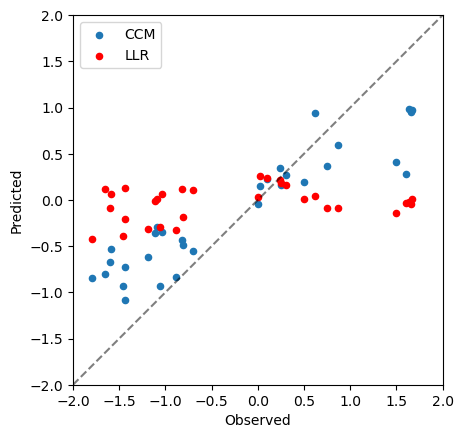

In [661]:
# Other Functions
def mean_bias_error(xx, yy):
    # Calculate mean bias error
    mbe = np.mean(np.abs(yy-xx))
    return(mbe)

In [662]:
test = CCM_anoms_NC[['Observations', 'Predictions', 'wyear']].groupby(by='wyear').mean()
wtf = test.apply(lambda x: mean_bias_error(x['Observations'], x['Predictions']), axis=1)

In [663]:
test2 = LM_anoms_NC[['swe_level2','SWE_lm_pred', 'wyear']].groupby(by='wyear').mean()
wtf2 = test2.apply(lambda x: mean_bias_error(x['swe_level2'], x['SWE_lm_pred']), axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


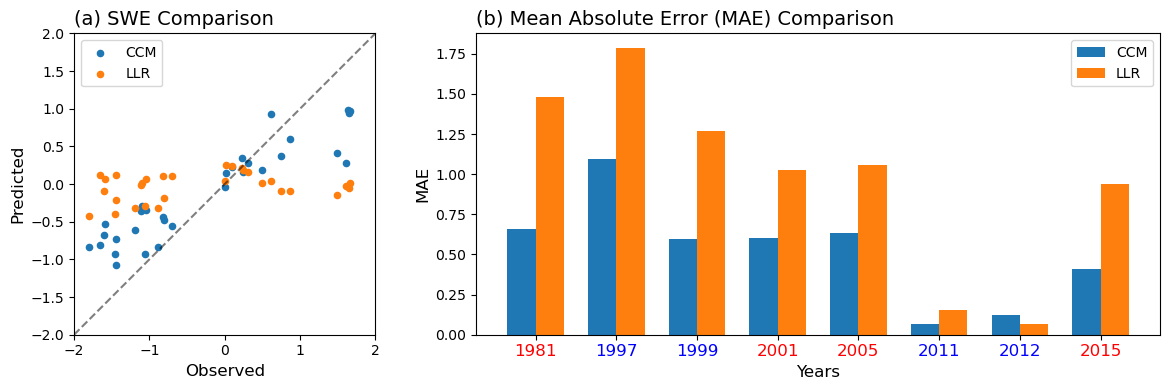

In [701]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,2, width_ratios = [1,2], height_ratios=[1])
ax1 = fig.add_subplot(gs[0])
ax1.set_aspect('equal', adjustable='box')

ax1.plot(np.arange(-2,2.1,0.1),np.arange(-2,2.1,0.1), ls='--', color='k', alpha=0.5)
CCM_anoms_NC.plot(ax=ax1, kind='scatter', x='Observations', y='Predictions', label='CCM')
LM_anoms_NC.plot(ax=ax1, kind='scatter', x='swe_level2', y='SWE_lm_pred', label='LLR', color='tab:orange')

ax1.set_title('(a) SWE Comparison', fontsize=14, loc='left')
ax1.set_xlabel('Observed', fontsize=12)
ax1.set_ylabel('Predicted', fontsize=12)
ax1.axis([-2,2,-2,2])

ax2 = fig.add_subplot(gs[1])
width=0.35
x = np.arange(len(wtf))
ax2.bar(height = wtf, x=x-width/2, width=width, label='CCM')
ax2.bar(height = wtf2, x=x+width/2, width=width, label='LLR')

# label_col = 

ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels(wtf.index, size=12)
[t.set_color(i) for (i,t) in zip(['red','blue','blue','red','red','blue','blue','red'],ax2.xaxis.get_ticklabels())]
ax2.set_xlabel('Years', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('(b) Mean Absolute Error (MAE) Comparison', fontsize=14, loc='left')
plt.tight_layout()
plt.savefig(pub_dir+'fig_a__b.eps',
            bbox_inches='tight',
            facecolor='w',
            dpi=300)

plt.show()

In [623]:
LM_anoms_NC[['swe_level2','SWE_lm_pred', 'wyear']].groupby(by='wyear').mean()

,swe_level2,SWE_lm_pred
wyear,,
1974,1.085061,NaN
1975,0.503637,0.178654
1976,0.950030,0.117296
1978,0.182158,0.020833
1981,-1.374774,0.104297
1999,1.184933,-0.084399
2001,-0.986656,0.042345
2005,-1.258832,-0.199493
2015,-1.298140,-0.359244


In [635]:
CCM_anoms_Ca

,Time,Observations,Predictions,Pred_Variance,dtime,year,month,wyear
14,1980-12-01T00:00:00,-0.695234,0.256183,0.077164,1980-12-01,1980,12,1981
15,1981-01-01T00:00:00,-1.493853,-0.357801,0.379939,1981-01-01,1981,1,1981
16,1981-02-01T00:00:00,-1.481754,-0.047706,0.027878,1981-02-01,1981,2,1981
17,1981-03-01T00:00:00,-1.496783,-0.109815,0.220579,1981-03-01,1981,3,1981
26,1981-12-01T00:00:00,0.383392,0.467030,0.232747,1981-12-01,1981,12,1982
27,1982-01-01T00:00:00,1.380816,0.255396,0.018130,1982-01-01,1982,1,1982
28,1982-02-01T00:00:00,1.119212,-0.063934,0.094736,1982-02-01,1982,2,1982
29,1982-03-01T00:00:00,0.904157,0.120251,0.093268,1982-03-01,1982,3,1982
110,1988-12-01T00:00:00,0.427099,-0.021231,0.383801,1988-12-01,1988,12,1989
111,1989-01-01T00:00:00,0.896494,0.258787,0.588510,1989-01-01,1989,1,1989


In [624]:
swe_re_ccm_l6_NC

,Time,Observations,Predictions,Pred_Variance,dtime,year,month,wyear
0,1978-06-01T00:00:00,-0.570056,0.226266,0.343903,1978-06-01,1978,6,1978
1,1978-10-01T00:00:00,-0.713971,0.069211,0.338039,1978-10-01,1978,10,1979
2,1978-11-01T00:00:00,-0.613949,-0.245393,0.246618,1978-11-01,1978,11,1979
3,1978-12-01T00:00:00,0.108471,-0.047328,0.057462,1978-12-01,1978,12,1979
4,1979-01-01T00:00:00,0.157904,-0.137415,0.084545,1979-01-01,1979,1,1979
...,...,...,...,...,...,...,...,...
484,2019-05-01T00:00:00,-0.754103,-0.164909,0.267106,2019-05-01,2019,5,2019
485,2019-06-01T00:00:00,-0.500688,-0.112784,0.380470,2019-06-01,2019,6,2019
486,2019-07-01T00:00:00,-0.119939,-0.039450,0.342706,2019-07-01,2019,7,2019
487,2019-08-01T00:00:00,-0.258992,-0.025387,0.349698,2019-08-01,2019,8,2019


In [636]:
test = CCM_anoms_Ca[['Observations', 'Predictions', 'wyear']].groupby(by='wyear').mean()
wtf = test.apply(lambda x: mean_bias_error(x['Observations'], x['Predictions']), axis=1)

In [637]:
test

,Observations,Predictions
wyear,,
1981,-1.291906,-0.064785
1982,0.946894,0.194686
1989,0.670608,0.071772
1992,-0.694723,-0.234801
1997,1.560260,0.237097
1999,0.946369,0.377581
2001,-0.708550,0.107248
2005,-0.890146,-0.222847
2008,0.881853,0.497268


In [702]:
swe_re_ccm_l1_Ca


,Time,Observations,Predictions,Pred_Variance,dtime
0,1978-12-01T00:00:00,-0.449708,0.136775,0.083483,1978-12-01
1,1979-01-01T00:00:00,-0.730925,0.077885,0.515444,1979-01-01
2,1979-02-01T00:00:00,-0.564041,-0.146861,0.138849,1979-02-01
3,1979-03-01T00:00:00,-0.471018,0.184241,0.748725,1979-03-01
4,1979-04-01T00:00:00,-0.336777,-0.368504,0.044091,1979-04-01
...,...,...,...,...,...
485,2019-05-01T00:00:00,-0.279344,-0.023091,0.442647,2019-05-01
486,2019-06-01T00:00:00,-0.245479,-0.311478,0.305018,2019-06-01
487,2019-07-01T00:00:00,-0.271610,-0.538411,0.144455,2019-07-01
488,2019-08-01T00:00:00,-0.211882,-0.982531,0.402723,2019-08-01


In [705]:
# df_pre1999 = df[df['dtime'].dt.year<1999]
ccm_l1_pre1999 = swe_re_ccm_l1_Ca[swe_re_ccm_l1_Ca['dtime'].dt.year<1999]
# stats.pearsonr(reg_l1_swe, df['swe_level2'][1:])
print(stats.pearsonr(ccm_l1_pre1999['Observations'], ccm_l1_pre1999['Predictions']))

# df_pre1999 = df[df['dtime'].dt.year<1999]
ccm_l1_post1999 = swe_re_ccm_l1_Ca[swe_re_ccm_l1_Ca['dtime'].dt.year>1999]
# stats.pearsonr(reg_l1_swe, df['swe_level2'][1:])
print(stats.pearsonr(ccm_l1_post1999['Observations'], ccm_l1_post1999['Predictions']))


PearsonRResult(statistic=0.15708147086358942, pvalue=0.014644429130582717)
PearsonRResult(statistic=0.4721766138679096, pvalue=1.456713527427994e-14)


In [706]:
# df_pre1999 = df[df['dtime'].dt.year<1999]
ccm_l3_pre1999 = swe_re_ccm_l3_Ca[swe_re_ccm_l3_Ca['dtime'].dt.year<1999]
# stats.pearsonr(reg_l3_swe, df['swe_level2'][1:])
print(stats.pearsonr(ccm_l3_pre1999['Observations'], ccm_l3_pre1999['Predictions']))

# df_pre1999 = df[df['dtime'].dt.year<1999]
ccm_l3_post1999 = swe_re_ccm_l3_Ca[swe_re_ccm_l3_Ca['dtime'].dt.year>1999]
# stats.pearsonr(reg_l3_swe, df['swe_level2'][1:])
print(stats.pearsonr(ccm_l3_post1999['Observations'], ccm_l3_post1999['Predictions']))


PearsonRResult(statistic=0.1863456457966205, pvalue=0.003991332087735173)
PearsonRResult(statistic=0.4019890692875843, pvalue=1.2838243190926546e-10)


In [707]:
# df_pre1999 = df[df['dtime'].dt.year<1999]
ccm_l6_pre1999 = swe_re_ccm_l6_Ca[swe_re_ccm_l6_Ca['dtime'].dt.year<1999]
# stats.pearsonr(reg_l6_swe, df['swe_level2'][1:])
print(stats.pearsonr(ccm_l6_pre1999['Observations'], ccm_l6_pre1999['Predictions']))

# df_pre1999 = df[df['dtime'].dt.year<1999]
ccm_l6_post1999 = swe_re_ccm_l6_Ca[swe_re_ccm_l6_Ca['dtime'].dt.year>1999]
# stats.pearsonr(reg_l6_swe, df['swe_level2'][1:])
print(stats.pearsonr(ccm_l6_post1999['Observations'], ccm_l6_post1999['Predictions']))


PearsonRResult(statistic=0.25100199322685623, pvalue=0.00011520158105787357)
PearsonRResult(statistic=0.4321592600391714, pvalue=3.3362149230315472e-12)
